# Import libraries

In [1]:
import importlib
import semseg_functions
importlib.reload(semseg_functions)

from semseg_functions import train_model, make_predictions
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

c:\Users\JOKER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
# Load the Data from pickle file.
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

# Splitting the Data into Training and Validation Sets. 
X_train,X_val,Y_train,Y_val=train_test_split(
  images,labels,
  # test_size=0.2: 20% of the data is reserved for validation and 80% for training.
  test_size=0.2,
  # The condition >= np.median(labels.mean((1, 2))) creates a binary mask (True/False) 
  # based on whether the mean value is above or below the median.
  stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),
  random_state=42
  )

# Converting Data to PyTorch Tensors
X_train,X_val,Y_train,Y_val=(
  torch.FloatTensor(X_train).permute((0,3,1,2)),
  torch.FloatTensor(X_val).permute((0,3,1,2)),
  torch.LongTensor(Y_train),
  torch.LongTensor(Y_val)
  )

# Define Calculations

Compute Dice Scores

In [3]:
# The Dice coefficient is a measure of similarity between two sets.
# How similar the predicted mask is to the ground truth mask. It balances precision and recall.
# It ranges from 0 (no overlap) to 1 (perfect overlap).
# The formula is defined as:    
#         2⋅∣A∩B∣
# Dice=  ───────
#         ∣A∣+∣B∣

def dice_score(preds, targets, num_classes=3):
    scores = []
    preds = torch.argmax(torch.tensor(preds), dim=1).numpy()
    for cls in range(num_classes):
        pred_cls = (preds == cls).astype(int)
        true_cls = (targets.numpy() == cls).astype(int)
        intersection = (pred_cls * true_cls).sum()
        union = pred_cls.sum() + true_cls.sum()
        score = (2. * intersection) / (union + 1e-6)
        scores.append(score)
    return scores

Add IoU (Intersection over Union)

In [4]:
# The proportion of overlap between predicted and ground truth areas relative to their combined area.
# It ranges from 0 (no overlap) to 1 (perfect overlap).
# The formula is defined as:
#         ∣A∩B∣
# IoU = ────────
#         ∣A∪B∣
def iou_score(preds, targets, num_classes=3):
    scores = []
    preds = torch.argmax(torch.tensor(preds), dim=1).numpy()
    for cls in range(num_classes):
        pred_cls = (preds == cls).astype(int)
        true_cls = (targets.numpy() == cls).astype(int)
        intersection = (pred_cls & true_cls).sum()
        union = (pred_cls | true_cls).sum()
        score = intersection / (union + 1e-6)
        scores.append(score)
    return scores

Define N/C Ratio Error

In [5]:
# The error in estimating the ratio of nucleus area to cytoplasm area in a cell.
# The function should return the mean absolute error between predicted and true ratios.
def nc_ratio_error(preds, targets, nucleus_cls=2, cyto_cls=1):
    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.detach().cpu().numpy()

    preds = np.argmax(preds, axis=1)

    # Function to compute the ratio of nucleus area to cytoplasm area.
    def compute_ratio(mask, cls1, cls2):
        nucleus_area = (mask == cls1).sum()
        cyto_area = (mask == cls2).sum()
        if cyto_area == 0: return None  
        return nucleus_area / cyto_area

    errors = []
    for pred_mask, true_mask in zip(preds, targets):
        # Compute the ratio of nucleus area to cytoplasm area for both predicted and true masks.
        pred_ratio = compute_ratio(pred_mask, nucleus_cls, cyto_cls)
        true_ratio = compute_ratio(true_mask, nucleus_cls, cyto_cls)
        if pred_ratio is None or true_ratio is None:
            continue
        errors.append(abs(pred_ratio - true_ratio))
    print("Example pred ratio:", pred_ratio, "true ratio:", true_ratio)
    return np.mean(errors) if errors else np.nan



# Training and Predictions

In [6]:

models = ["unet", "fpn", "unetplusplus", "seunettrans"]
encoder = "densenet121"
results = []
results_dict = {}

for model_key in models:
    model, training_loss, validation_loss = train_model(X_train, Y_train, X_val, Y_val, model_key=model_key, encoder_name=encoder, n_epochs=75)
    preds = make_predictions(X_val, model=model, model_key=model_key, encoder_name=encoder)
    
    dice = dice_score(preds, Y_val)
    iou = iou_score(preds, Y_val)
    nc_error = nc_ratio_error(preds, Y_val)

    # Find the best epoch
    best_epoch = np.argmin(validation_loss)
    best_val_loss = validation_loss[best_epoch]

    results.append({
        "Model": model_key,
        "Dice_0": dice[0], "Dice_1": dice[1], "Dice_2": dice[2],
        "IoU_0": iou[0], "IoU_1": iou[1], "IoU_2": iou[2],
        "N/C Error": nc_error
    })

    results_dict[model_key] = {
        "training_loss": training_loss,
        "validation_loss": validation_loss,
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss
    }

Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 0, Loss: 1.626
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 1, Loss: 1.41
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 2, Loss: 1.406
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 3, Loss: 1.294
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 4, Loss: 1.133
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 5, Loss: 1.203
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 6, Loss: 1.11
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 7, Loss: 1.096
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 8, Loss: 1.058
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 9, Loss: 0.91
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 10, Loss: 0.892
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 11, Loss: 0.938
Model: unet, Encoder: densenet121. Training: Epoch 1, Batch 12, Loss: 0.829
Model: unet, Encoder: den

# Training Progress

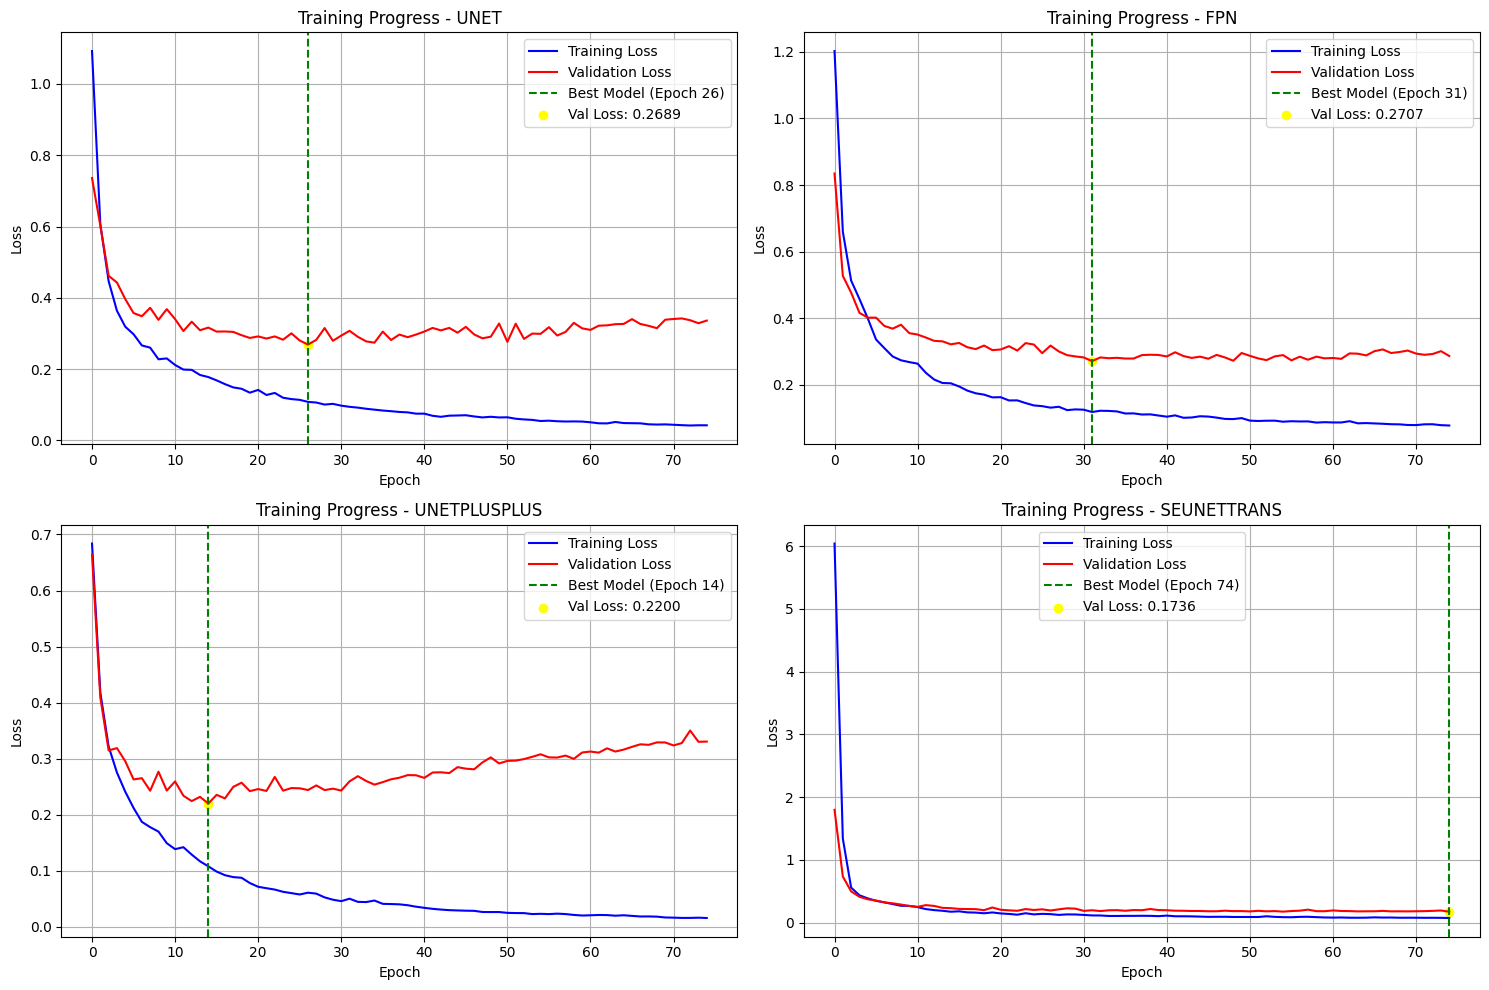

In [7]:
# Plot training progress for each model
plt.figure(figsize=(15, 10))

# Determine the global y-axis limits based on the maximum loss across all models
all_training_losses = [loss for model_key in models for loss in results_dict[model_key]["training_loss"]]
all_validation_losses = [loss for model_key in models for loss in results_dict[model_key]["validation_loss"]]
global_y_max = max(max(all_training_losses), max(all_validation_losses))
global_y_min = min(min(all_training_losses), min(all_validation_losses))

for idx, model_key in enumerate(models):

    training_loss = results_dict[model_key]["training_loss"]
    validation_loss = results_dict[model_key]["validation_loss"]
    best_epoch = results_dict[model_key]["best_epoch"]
    best_val_loss = validation_loss[best_epoch]

    plt.subplot(2, 2, idx + 1)
    plt.plot(training_loss, label="Training Loss", color="blue")
    plt.plot(validation_loss, label="Validation Loss", color="red")
    plt.axvline(x=best_epoch, color="green", linestyle="--", label=f"Best Model (Epoch {best_epoch})")
    plt.scatter(best_epoch, best_val_loss, color="yellow", label=f"Val Loss: {best_val_loss:.4f}")

    plt.title(f"Training Progress - {model_key.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Set consistent y-axis limits
    # plt.ylim(global_y_min, global_y_max)

plt.tight_layout()
plt.show()

# Convert to Table

In [8]:

results_df = pd.DataFrame(results)
results_df.set_index("Model", inplace=True)
display(results_df)

,Dice_0,Dice_1,Dice_2,IoU_0,IoU_1,IoU_2,N/C Error
Model,,,,,,,
unet,0.965261,0.877992,0.830365,0.932855,0.782519,0.709935,0.268427
fpn,0.955551,0.878236,0.838637,0.914885,0.782907,0.722114,0.208652
unetplusplus,0.969758,0.900053,0.861124,0.941292,0.818270,0.756117,0.194103
seunettrans,0.966153,0.903200,0.856745,0.934523,0.823487,0.749391,0.190914


# Bar Plots for Metric Comparison

Dice score

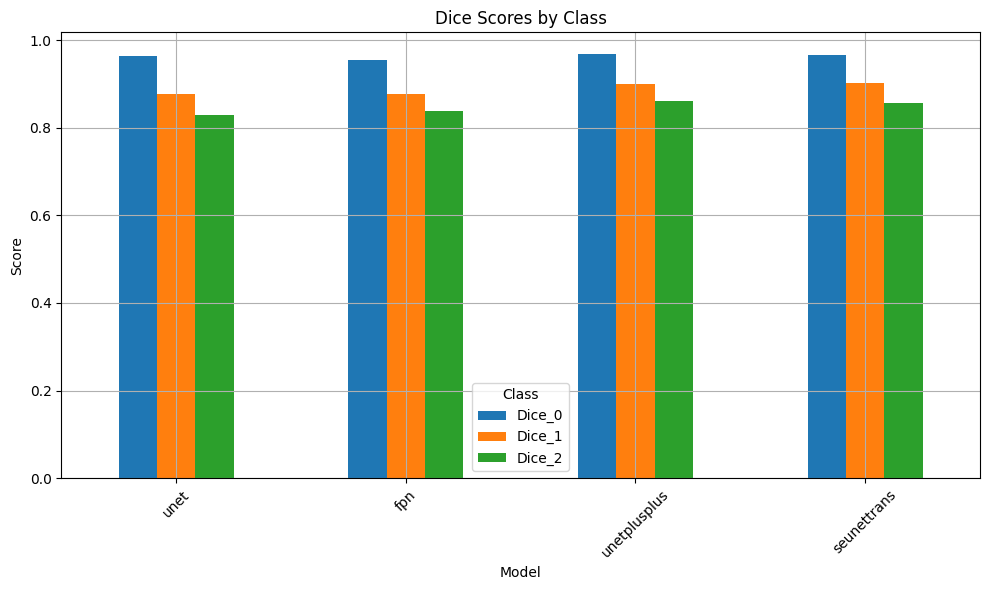

In [9]:

dice_cols = ['Dice_0', 'Dice_1', 'Dice_2']
results_df[dice_cols].plot(kind='bar', figsize=(10, 6))
plt.title("Dice Scores by Class")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Class")
plt.grid(True)
plt.tight_layout()
plt.show()

IoU score

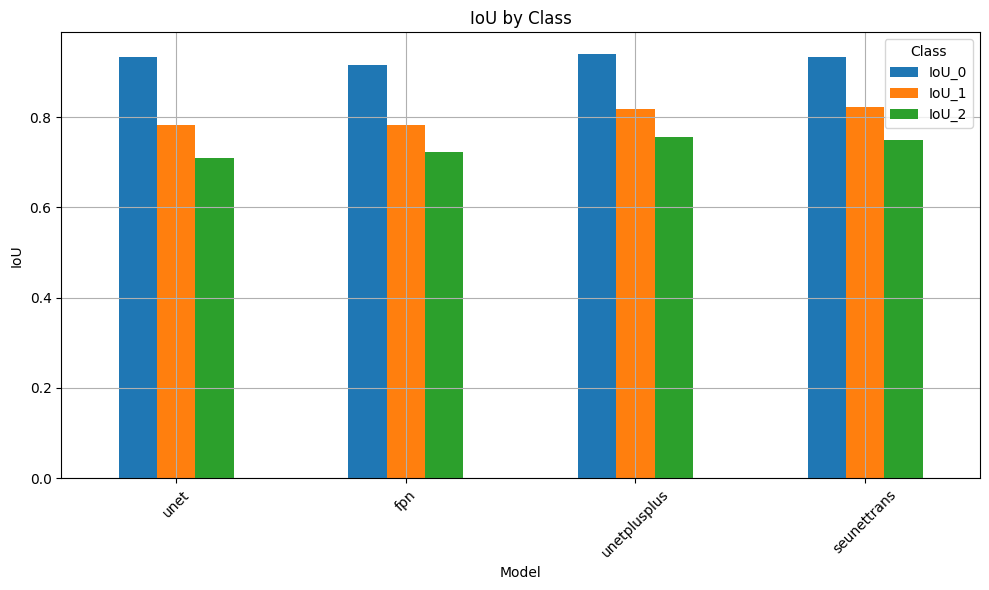

In [10]:
IoU_cols = ['IoU_0', 'IoU_1', 'IoU_2']
results_df[IoU_cols].plot(kind='bar', figsize=(10, 6))
plt.title("IoU by Class")
plt.ylabel("IoU")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Class")
plt.grid(True)
plt.tight_layout()
plt.show()

# Line Plot of N/C Error

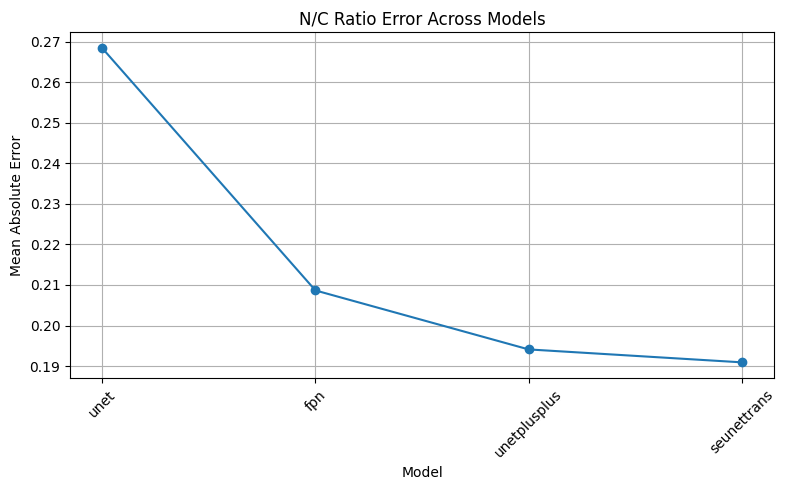

In [11]:

results_df['N/C Error'].plot(kind='line', marker='o', figsize=(8, 5))
plt.title("N/C Ratio Error Across Models")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Model")
plt.xticks(ticks=range(len(results_df)), labels=results_df.index, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap of All Metrics

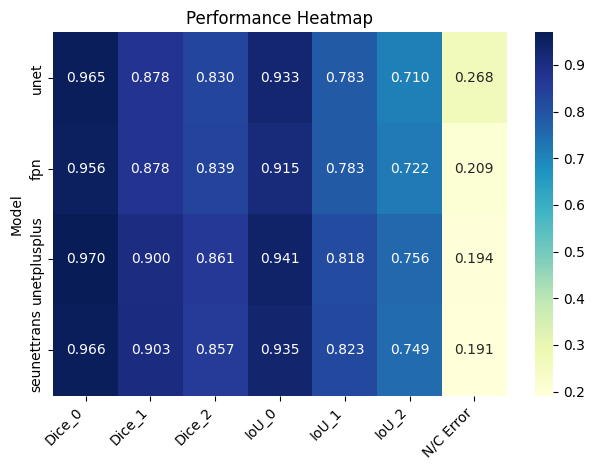

In [12]:

sns.heatmap(results_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Performance Heatmap")
plt.ylabel("Model")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()